GNN-based Recommendation System

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 976.2 kB/s eta 0:00:00


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/incomplete.6KSQFI_0.1.1/movielens-train.tfrecord*..…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/incomplete.RFCQHL_0.1.1/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.
Epoch 1/10
25/25 [==============================] - 15s 536ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0058 - factorized_top_k/top_10_categorical_accuracy: 0.0124 - loss: 32262.4076 - regularization_loss: 0.0000e+00 - total_loss: 32262.4076
Epoch 2/10
25/25 [==============================] - 13s 531ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0053 - factorized_top_k/top_10_categorical_accuracy: 0.0121 - loss: 31425.6151 - regularization_loss: 0.0000e+00 - total_loss: 31425.6151
Epoch 3/10
25/25 [==============================] - 13s 520ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0078 - factorized_top_k/top_10_categorical_accuracy: 0.0167 - loss: 30901.7791 - regularization_loss: 0.0000e+00 - total_loss: 30901.7791
Epoch 4/10
25/25 [==============================] - 13s 531ms/step - factorized_top_k/top_5_categor

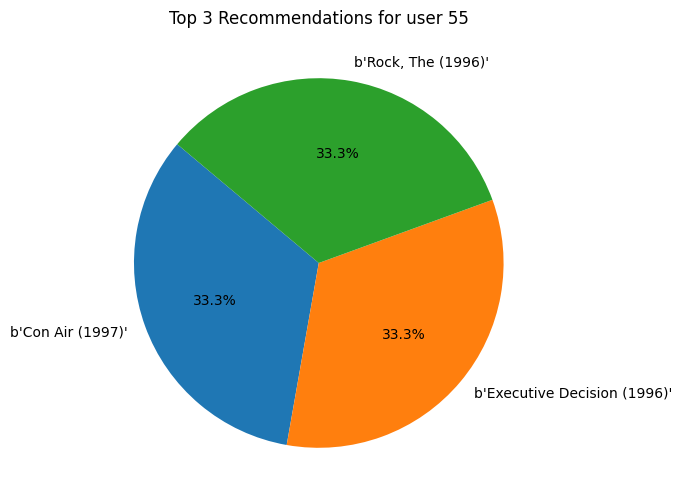

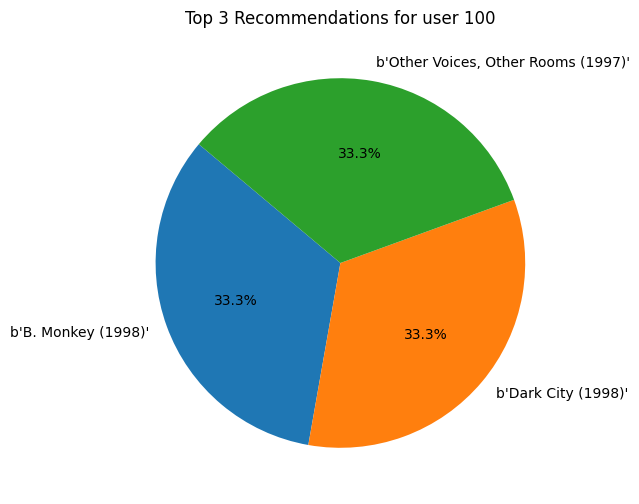

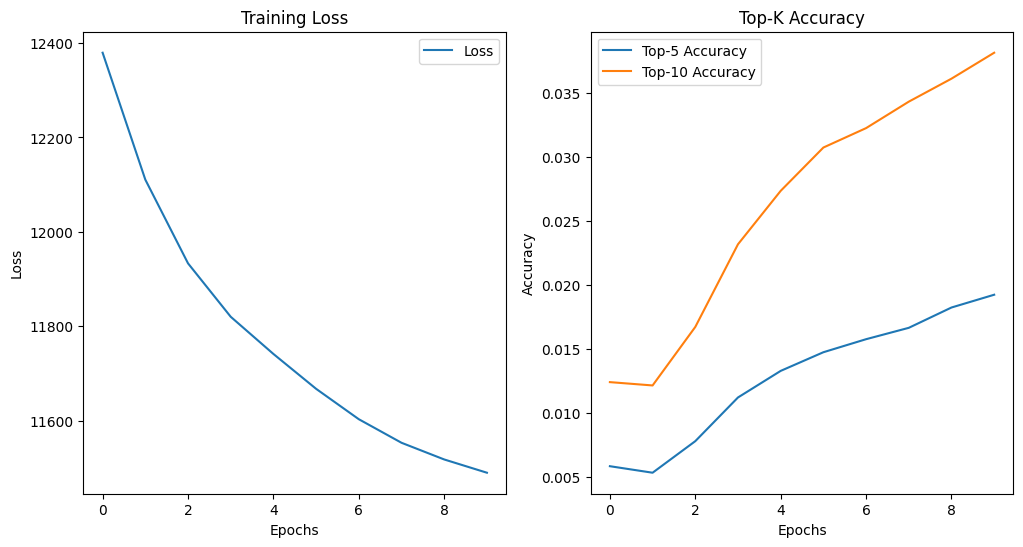

In [1]:
# Install the necessary libraries
!pip install -q tensorflow-recommenders matplotlib

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Load the MovieLens dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Prepare the data
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"]
})

movies = movies.map(lambda x: x["movie_title"])

# Define the user and movie model with additional features.
user_ids_vocabulary = tf.keras.layers.StringLookup()
movie_titles_vocabulary = tf.keras.layers.StringLookup()

user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))
movie_titles_vocabulary.adapt(movies)

# Convert the movie titles to a TensorFlow Dataset
movies = tf.data.Dataset.from_tensor_slices(list(movies))

# Define the GNN layer
class GNNLayer(layers.Layer):
    def __init__(self, units):
        super(GNNLayer, self).__init__()
        self.units = units
        self.dense = layers.Dense(units)

    def call(self, inputs, edge_index):
        x = inputs
        row, col = edge_index[:, 0], edge_index[:, 1]
        out = tf.math.unsorted_segment_sum(x[col], row, num_segments=tf.shape(x)[0])
        return self.dense(out)

class GNNModel(tfrs.Model):
    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task

    def call(self, features):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        edge_index = tf.stack([features["user_id"], features["movie_title"]], axis=1)
        gnn_layer = GNNLayer(64)
        user_embeddings = gnn_layer(user_embeddings, edge_index)
        movie_embeddings = gnn_layer(movie_embeddings, edge_index)
        return self.task(user_embeddings, movie_embeddings)

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, movie_embeddings)

# Define user and movie models
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

# Define the task
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    candidates=movies.batch(128).map(movie_model),
    ks=[5, 10]
))

# Create and compile the model
model = GNNModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

# Train the model and capture the training history
history = model.fit(ratings.batch(4096), epochs=10, verbose=1)

# Set up brute-force search for retrieval
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)

# Function to get recommendations for a specific user and plot a pie chart
def plot_recommendation_pie_chart(user_id):
    _, titles = index(np.array([user_id]))
    top_3_titles = titles[0, :3].numpy()
    unique_titles, counts = np.unique(top_3_titles, return_counts=True)

    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=unique_titles, autopct='%1.1f%%', startangle=140)
    plt.title(f'Top 3 Recommendations for user {user_id}')
    plt.show()

# Get recommendations for a specific user and plot the pie chart
plot_recommendation_pie_chart("55")

# Get recommendations for another user and plot the pie chart
plot_recommendation_pie_chart("100")

# Plot the training loss and top-k accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot top-5 and top-10 accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'], label='Top-5 Accuracy')
plt.plot(history.history['factorized_top_k/top_10_categorical_accuracy'], label='Top-10 Accuracy')
plt.title('Top-K Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


KNNModel

Epoch 1/10
25/25 [==============================] - 80s 3s/step - factorized_top_k/top_5_categorical_accuracy: 0.7191 - factorized_top_k/top_10_categorical_accuracy: 0.8440 - loss: 23726.0855 - regularization_loss: 0.0000e+00 - total_loss: 23726.0855
Epoch 2/10
25/25 [==============================] - 66s 3s/step - factorized_top_k/top_5_categorical_accuracy: 0.8954 - factorized_top_k/top_10_categorical_accuracy: 0.9690 - loss: 12344.6165 - regularization_loss: 0.0000e+00 - total_loss: 12344.6165
Epoch 3/10
25/25 [==============================] - 67s 3s/step - factorized_top_k/top_5_categorical_accuracy: 0.8424 - factorized_top_k/top_10_categorical_accuracy: 0.9706 - loss: 11195.7916 - regularization_loss: 0.0000e+00 - total_loss: 11195.7916
Epoch 4/10
25/25 [==============================] - 67s 3s/step - factorized_top_k/top_5_categorical_accuracy: 0.8355 - factorized_top_k/top_10_categorical_accuracy: 0.9626 - loss: 10511.9822 - regularization_loss: 0.0000e+00 - total_loss: 10511.9

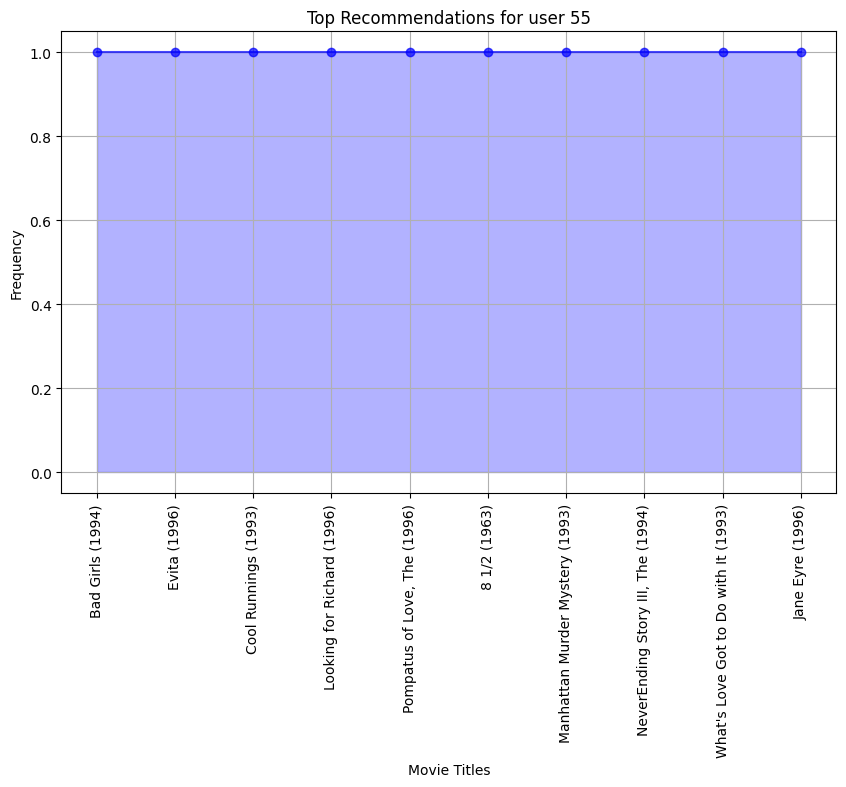

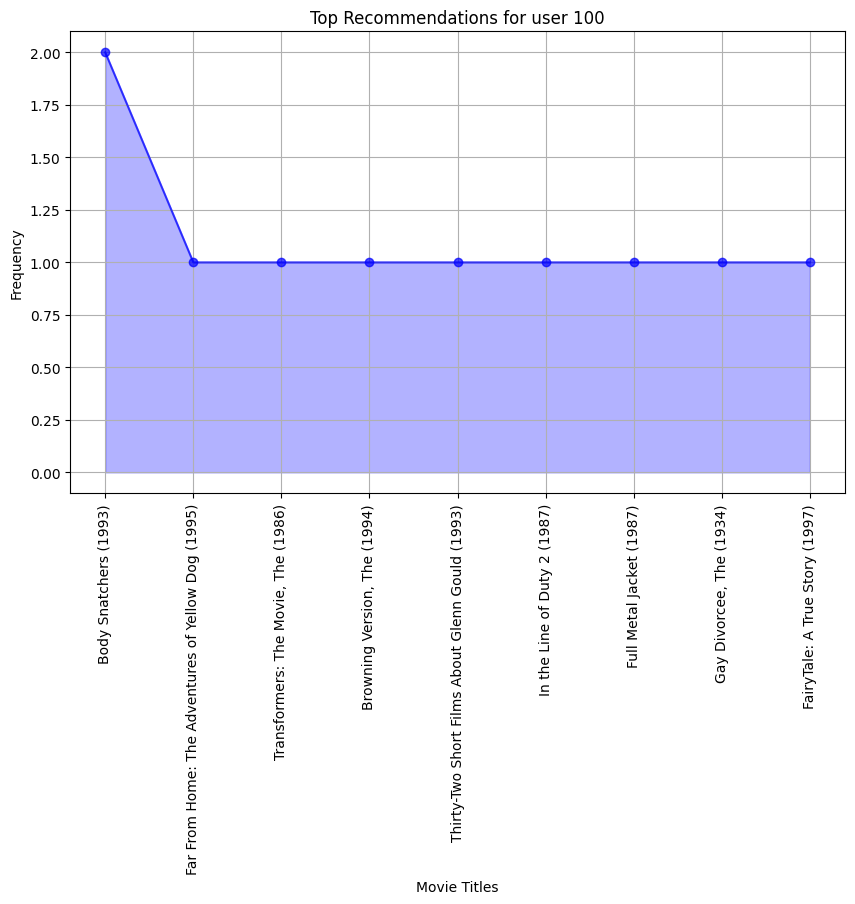

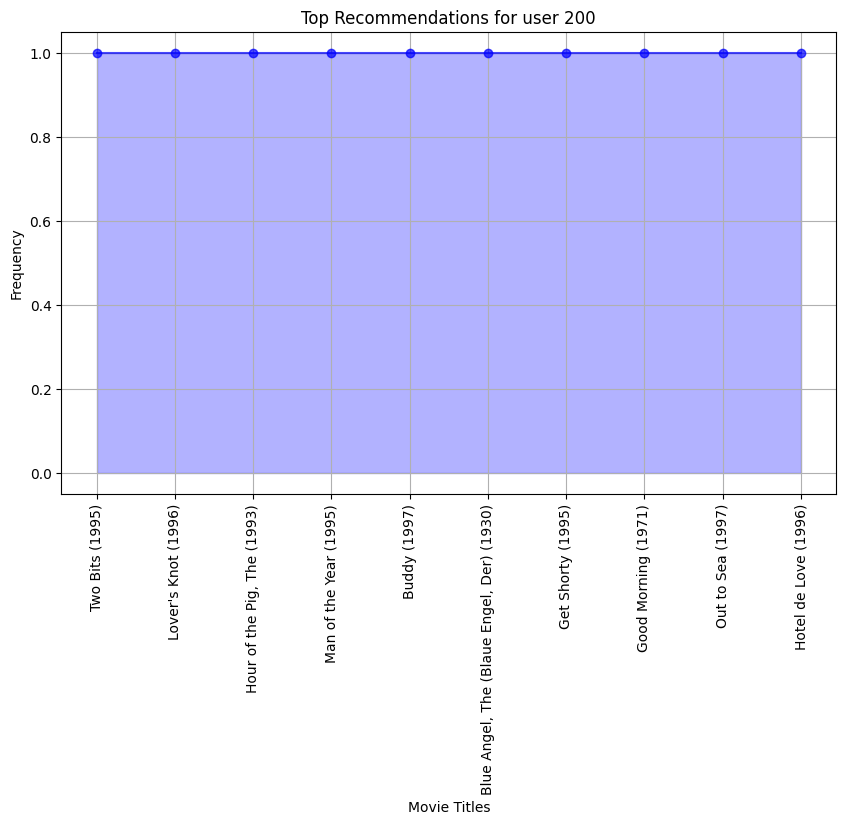

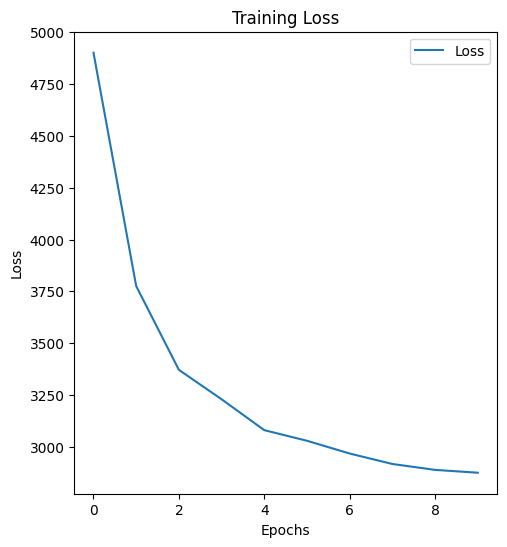

In [22]:
# Install necessary libraries
!pip install -q tensorflow-recommenders matplotlib

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Load the MovieLens dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Prepare the data
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"]
})

movies = movies.map(lambda x: x["movie_title"])

# Define the KNN layer
class KNNLayer(layers.Layer):
    def __init__(self, k):
        super(KNNLayer, self).__init__()
        self.k = k

    def call(self, inputs, queries):
        queries = tf.expand_dims(queries, axis=1)
        distances = tf.reduce_sum(tf.square(inputs - queries), axis=-1)
        _, indices = tf.math.top_k(-distances, k=self.k)
        return tf.reduce_mean(tf.gather(inputs, indices), axis=1)

# Define the KNN model for movie recommendations
class KNNModel(tfrs.Model):
    def __init__(self, user_model, movie_model, task, k):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task
        self.k = k
        self.knn_layer = KNNLayer(k)

    def call(self, features):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, self.knn_layer(movie_embeddings, user_embeddings))

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, self.knn_layer(movie_embeddings, user_embeddings))

# Define user and movie models with embeddings
user_ids_vocabulary = tf.keras.layers.StringLookup()
movie_titles_vocabulary = tf.keras.layers.StringLookup()

user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))
movie_titles_vocabulary.adapt(movies)

user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

# Define the retrieval task
task = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128).map(movie_model),
        ks=[5, 10]
    )
)

# Create and compile the KNN model
k = 10  # Number of nearest neighbors
knn_model = KNNModel(user_model, movie_model, task, k)
knn_model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

# Train the KNN model and capture the training history
history = knn_model.fit(ratings.batch(4096), epochs=10, verbose=1)

# Set up brute-force search for retrieval
index = tfrs.layers.factorized_top_k.BruteForce(knn_model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, knn_model.movie_model(title)))
)

# Function to get recommendations for a specific user and plot a frequency polygon
def plot_recommendation_frequency_polygon(user_id):
    _, titles = index(np.array([user_id]))
    top_titles = titles[0].numpy()

    title_counts = {}
    for title in top_titles:
        title_str = title.decode('utf-8')  # Convert bytes to string
        if title_str in title_counts:
            title_counts[title_str] += 1
        else:
            title_counts[title_str] = 1

    sorted_titles = sorted(title_counts.items(), key=lambda x: x[1], reverse=True)
    top_titles, counts = zip(*sorted_titles)

    plt.figure(figsize=(10, 6))
    plt.plot(top_titles, counts, marker='o', linestyle='-', color='b', alpha=0.7)
    plt.fill_between(top_titles, counts, color='b', alpha=0.3)
    plt.title(f'Top Recommendations for user {user_id}')
    plt.xlabel('Movie Titles')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

# Get recommendations for specific users and plot the frequency polygon
users_to_plot = ["55", "100", "200"]  # Example list of user IDs
for user_id in users_to_plot:
    plot_recommendation_frequency_polygon(user_id)

# Plot the training loss and top-k accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# No need to plot top-k accuracy for KNN model

plt.show()


 SessionBasedModel

Epoch 1/10
25/25 [==============================] - 15s 561ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0063 - factorized_top_k/top_10_categorical_accuracy: 0.0127 - loss: 32379.2923 - regularization_loss: 0.0000e+00 - total_loss: 32379.2923
Epoch 2/10
25/25 [==============================] - 14s 559ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0095 - factorized_top_k/top_10_categorical_accuracy: 0.0196 - loss: 31442.7381 - regularization_loss: 0.0000e+00 - total_loss: 31442.7381
Epoch 3/10
25/25 [==============================] - 15s 566ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0088 - factorized_top_k/top_10_categorical_accuracy: 0.0191 - loss: 30851.0208 - regularization_loss: 0.0000e+00 - total_loss: 30851.0208
Epoch 4/10
25/25 [==============================] - 14s 572ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0119 - factorized_top_k/top_10_categorical_accuracy: 0.0255 - loss: 30503.7088 - regularization_loss: 0.0000e+00 - total_l

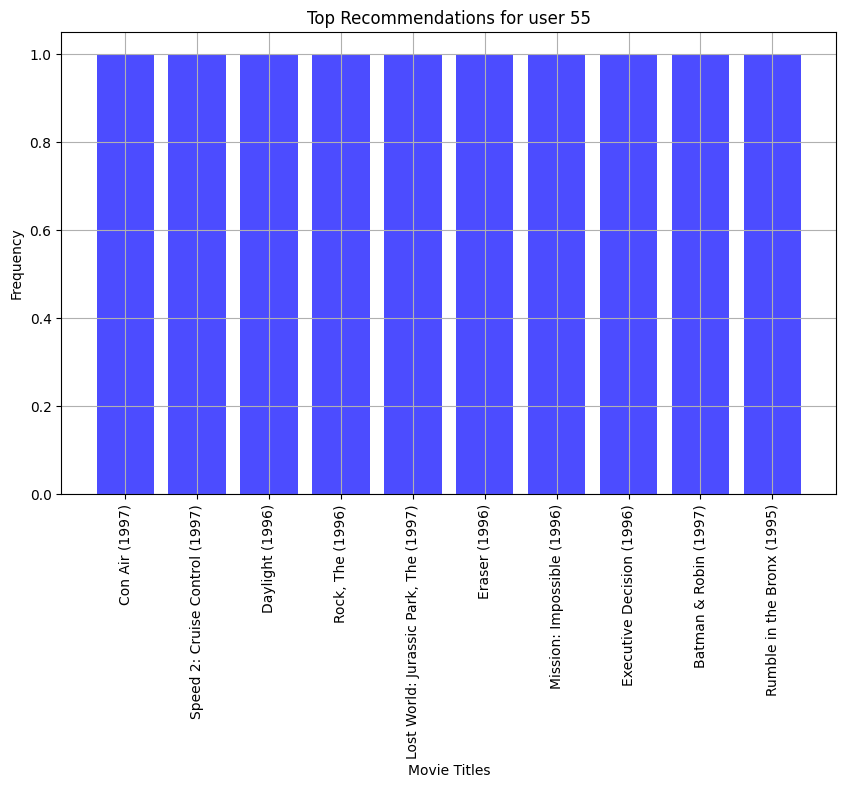

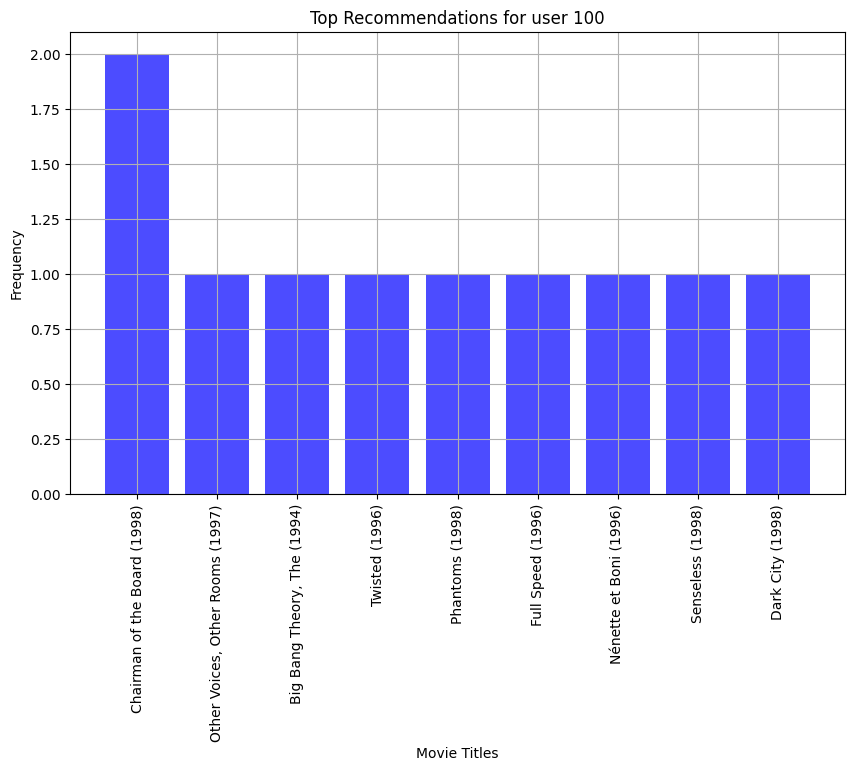

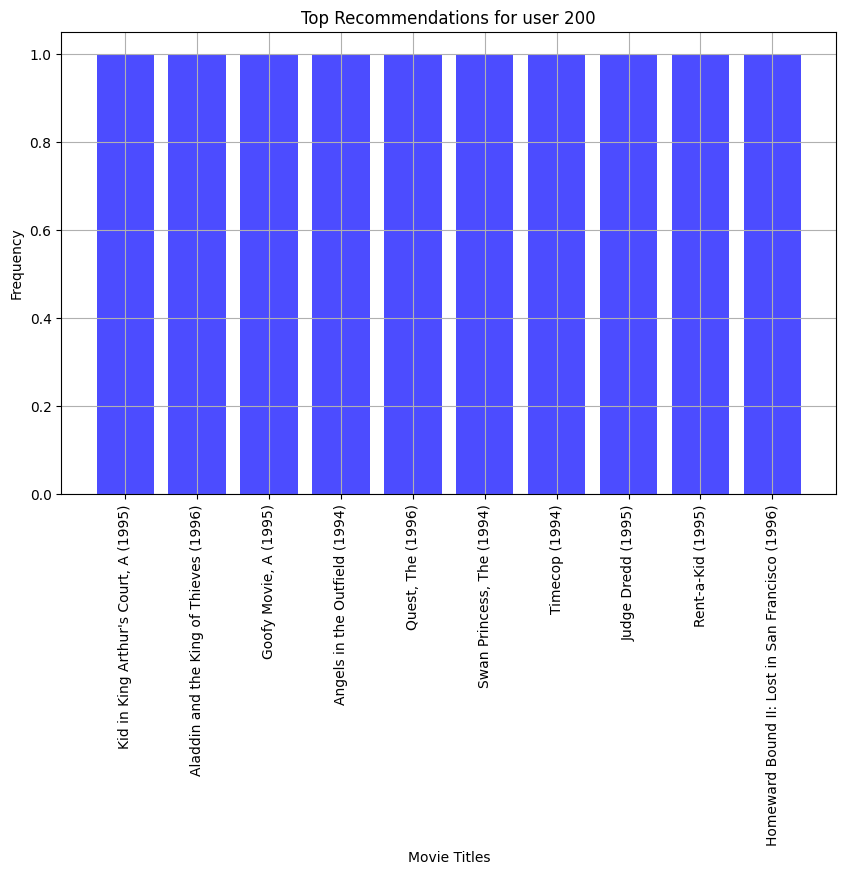

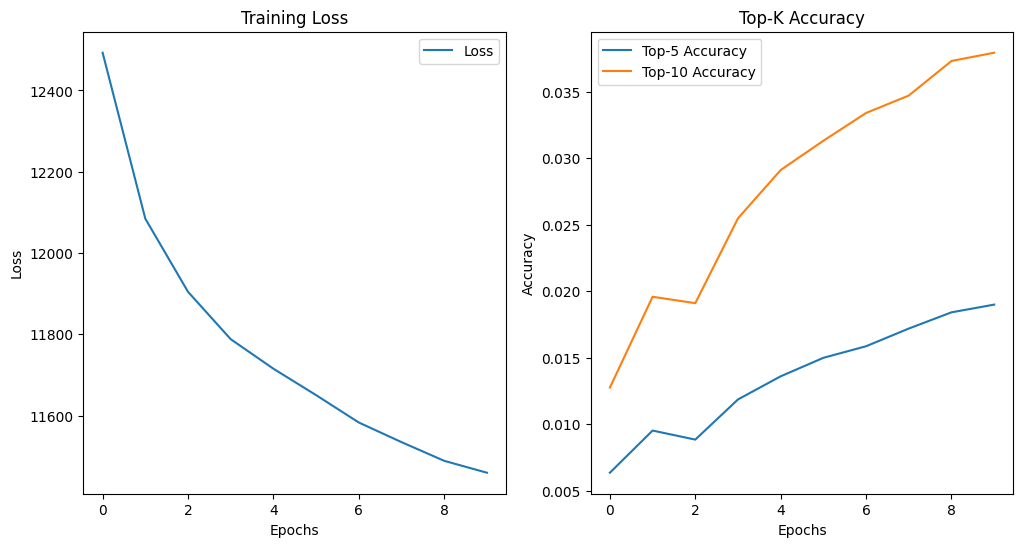

In [21]:
# Install necessary libraries
!pip install -q tensorflow-recommenders matplotlib

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Load the MovieLens dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Prepare the data
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"]
})

movies = movies.map(lambda x: x["movie_title"])

# Define user and movie models with embeddings
user_ids_vocabulary = tf.keras.layers.StringLookup()
movie_titles_vocabulary = tf.keras.layers.StringLookup()

user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))
movie_titles_vocabulary.adapt(movies)

user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

# Define the retrieval task
task = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128).map(movie_model),
        ks=[5, 10]
    )
)

# Create and compile the session-based recommendation model
class SessionBasedModel(tfrs.Model):
    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, movie_embeddings)

session_model = SessionBasedModel(user_model, movie_model, task)
session_model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

# Train the session-based recommendation model and capture the training history
history = session_model.fit(ratings.batch(4096), epochs=10, verbose=1)

# Set up brute-force search for retrieval
index = tfrs.layers.factorized_top_k.BruteForce(session_model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, session_model.movie_model(title)))
)

# Function to get recommendations for a specific user and plot a column graph
def plot_recommendation_column_graph(user_id):
    _, titles = index(np.array([user_id]))
    top_titles = titles[0].numpy()

    title_counts = {}
    for title in top_titles:
        title_str = title.decode('utf-8')  # Convert bytes to string
        if title_str in title_counts:
            title_counts[title_str] += 1
        else:
            title_counts[title_str] = 1

    sorted_titles = sorted(title_counts.items(), key=lambda x: x[1], reverse=True)
    top_titles, counts = zip(*sorted_titles)

    plt.figure(figsize=(10, 6))
    plt.bar(top_titles, counts, color='blue', alpha=0.7)
    plt.title(f'Top Recommendations for user {user_id}')
    plt.xlabel('Movie Titles')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

# Get recommendations for specific users and plot the column graph
users_to_plot = ["55", "100", "200"]  # Example list of user IDs
for user_id in users_to_plot:
    plot_recommendation_column_graph(user_id)

# Plot the training loss and top-k accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot top-5 and top-10 accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'], label='Top-5 Accuracy')
plt.plot(history.history['factorized_top_k/top_10_categorical_accuracy'], label='Top-10 Accuracy')
plt.title('Top-K Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
